<div align="center">

# Vehicule's License Plate Detection

 </div>

Vehicle License plate detection and recognition is a well-known challenge that has been tackled by many computer-vision labs and companies. However, each country has its own specific license plate formats. This challenge is targeting regular Tunisian license plates. The data provided for this challenge is composed of two datasets:
A set of vehicle images (900 images) taken from the internet and annotated manually. The annotations are the coordinates of the bounding box containing the license plate.
A set of license plate images (900 images) where the annotations are the text written in the license plate.

The project will be hold in 3 phases:
1. Exploratory Data Analysis (EDA) phase, where you are supposed to work on understanding, clearing, sorting and extracting important features from the data provided. **Estimated Task Time:** 1 day

2. Modeling phase, where you will be able to use all the work done in EDA in order to create your own DL model (or models). **Estimated Task Time:** 3 days



In [163]:
import cv2
import  tensorflow as tf
import pandas as pd
import numpy as np



from project.image_preprocess.data_aug.data_aug import *
from project.image_preprocess.data_aug.bbox_util import *

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.pyplot import figure

import random

from PIL import Image

## Exploratory Data Analysis

First, let's load the training the data and explore the shape of the images.

In [164]:
def load_data(path):
    """
    loads the labels and their images
    
    :path path to the data directory
    """
    # L
    df_target = pd.read_csv(f'{path}/train_target.csv')
    # load the images in the same order of the target DF
    images = []
    images_metadata = {
        'width':[],
        'height':[]
    }
    for image in df_target['img_id']:
        images.append(np.array(Image.open(f'{path}/train/{image}')))
        # Getting information about the images shape 
        images_metadata['height'].append(images[-1].shape[1])
        images_metadata['width'].append(images[-1].shape[0])
    df_target['heights'] = images_metadata['height']
    df_target['width'] = images_metadata['width']
    return images, df_target

images, targets = load_data('./data')

### Check that all images have 3 channels

In [166]:
assert np.array([image.shape[2] == 3 for image in images]).all()

### Check the shape of the images

Text(0, 0.5, 'Count')

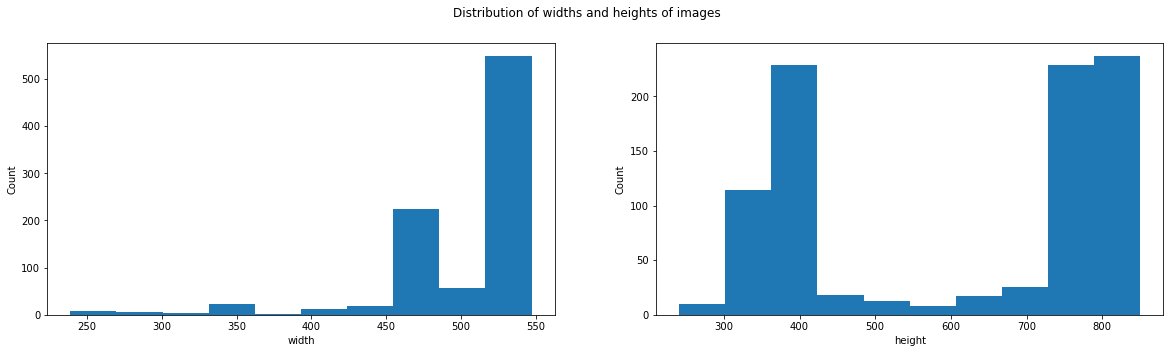

In [165]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Distribution of widths and heights of images')
axs[0].hist(targets['width'])
axs[0].set_xlabel('width')
axs[0].set_ylabel('Count')
axs[1].hist(targets['heights'])
axs[1].set_xlabel('height')
axs[1].set_ylabel('Count')

The plots above show that the images are not of the same size and we should fix problem as the NN will only accept a fixed shape as input

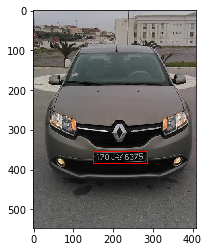

In [5]:
def plot_image(image, x_min, y_min, x_max, y_max):
    """
    Plots the image of the car with a bounding box around the licence plate
    
    :image: the image of the car
    :x_min : the minimum x position of the box
    :y_min : the minimum y position of the box
    :x_max : the maximum x position of the box
    :y_max : the maximum y position of the box
    """
    # Create figure and axes
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(image)
    # Create a Rectangle patch
    rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()
    

def plot_random_image(images, targets, index=None):
    """
    Plots a random image (or the image at the position index)
    """
    if index is None:
        index = random.randint(0, len(images))
    y_min, x_min, y_max, x_max = targets.iloc[index][['ymin', 'xmin', 'ymax', 'xmax' ]]
    plot_image(images[index], x_min, y_min, x_max, y_max)
    
    
plot_random_image(images, targets)

### Distribution of plates position in the images

[]

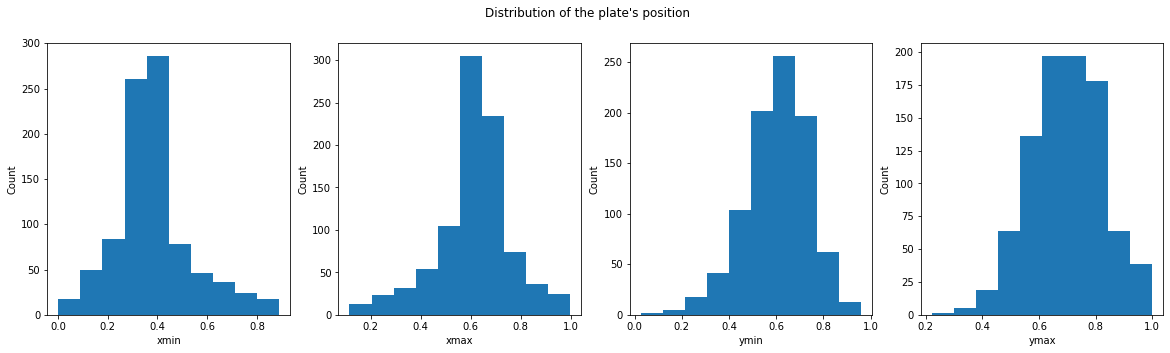

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
fig.suptitle("Distribution of the plate's position")

tmp_targets = targets.copy()

divide = lambda x,y: x/y

tmp_targets[['xmin', 'xmax']] = tmp_targets[['xmin', 'xmax']].values / tmp_targets['heights'].values.reshape(-1,1)
tmp_targets[['ymin', 'ymax']] = tmp_targets[['ymin', 'ymax']].values / tmp_targets['width'].values.reshape(-1,1)

columns = ['xmin', 'xmax', 'ymin',  'ymax']

for i in range(len(columns)):
    axs[i].hist(tmp_targets[columns[i]])
    axs[i].set_xlabel(columns[i])
    axs[i].set_ylabel('Count')
plt.plot()

The above distribution shows that the plates in the proposed dataset are mostely centered around one position. This would mean that we have some bias?!

## Suggested Solution

**Objective** The objective of this challenge is 
1. to detect the vehicle’s license plates then 
2. recognize the characters in each license plate. 

The proposed solution is as follows

<img src='system.png' />

## Data Pre-processing

In [167]:
# Change all images to the same shape
def reshape(image, plate_position, new_size=224):
    img_, bboxes_ = Resize(new_size)(image.copy(), plate_position.copy())
    return img_, bboxes_
    
def reshape_images(images,target_df, new_shape=224):
    new_images =[]
    new_position = []
    
    for i in range(len(images)):
        plate_position = target_df.loc[i, ['xmin','ymin', 'xmax', 'ymax' ]].values.reshape(1,-1)
        resized_image, new_box = reshape(images[i], plate_position, new_shape)
        new_images.append(resized_image)
        new_position.append([new_box ])

    new_targets = pd.DataFrame(np.array(new_position).reshape(-1,4))
    new_targets.columns = ['xmin', 'ymin', 'xmax', 'ymax' ]
    new_targets[[ 'xmin', 'ymin',  'xmax', 'ymax']] = new_targets[[ 'xmin', 'ymin',  'xmax', 'ymax']].astype(int)
    new_targets ['img_id'] = target_df['img_id']
    return new_images, new_targets
    

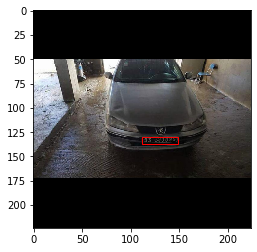

In [168]:
new_images, new_targets = reshape_images(images, targets)
plot_random_image(new_images, new_targets)

In [9]:
img = new_images[10]
bboxes = new_targets.iloc[10][[ 'xmin', 'ymin',  'xmax', 'ymax']].values.reshape(1,-1)

img_1, bboxes_1 = RandomHorizontalFlip(1)(img.copy(), bboxes.copy())
img_2, bboxes_2 = RandomScale(0.3, diff = True)(img.copy(), bboxes.copy())
img_3, bboxes_3 = RandomTranslate(0.3, diff = True)(img.copy(), bboxes.copy())
img_4, bboxes_4 = RandomRotate(20)(img.copy(), bboxes.copy())
img_5, bboxes_5 =  RandomShear(0.2)(img.copy(), bboxes.copy())
img_6, bboxes_6 = RandomHSV(100, 100, 100)(img.copy(), bboxes.copy())

seq = Sequence([RandomHSV(40, 40, 30),RandomHorizontalFlip(), RandomScale(), RandomTranslate(), RandomRotate(10), RandomShear()])
img_7, bboxes_7 = seq(img.copy(), bboxes.copy())

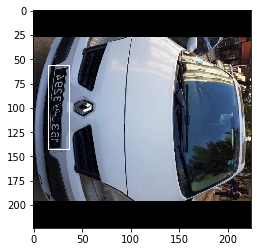

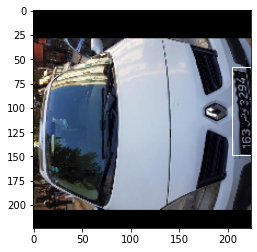

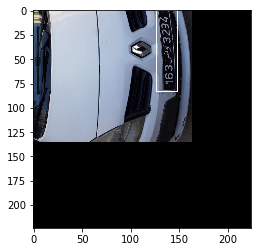

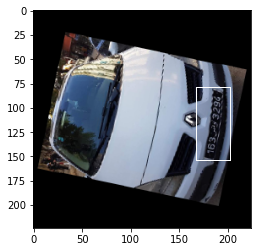

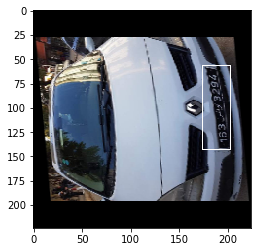

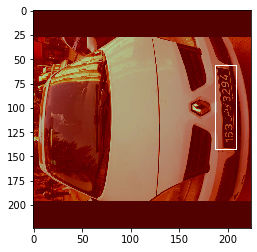

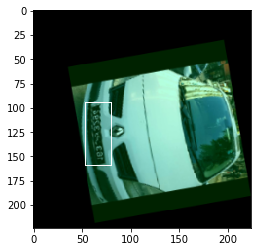

In [10]:
images_test = [(img_1, bboxes_1), 
               (img_2, bboxes_2), 
               (img_3, bboxes_3), 
               (img_4, bboxes_4), 
               (img_5, bboxes_5), 
               (img_6, bboxes_6), 
               (img_7, bboxes_7), ]

for im, box in images_test:
    plotted_img = draw_rect(im, box)
    plt.imshow(plotted_img)
    plt.show()


## Data augmentation

The task here is to augment the training images using random images from the library. As suggested in previous discussion, each image would generate 10 different images but the transformations should be random for each image. 

Please also check the distribution of xmin, xmax, ymin and ymin at the end.

**Expected output: A shared drive with 9000**

**Responsible: Chihab**

**Deadline: Wednesday**

## Plate position Detection

The task here is downlaod a pre-trained model for the licence plate detection. A model that only detects the position of the plate. 
1. First, test the model directly on the test set and measure the performance. if the performance is very good, we may use it directly. 

2. Then the model should be retrained on the augmented data from previous step. The performance should be measured once again on the test data.

**Expected output:** A shared drive containing the checkpoint for the model, 2 csv files for the training and validation losses and a csv file for the test predictions.

**Responsible:** Abla

**Deadline for 1:** Wednesday

**Deadline for 2:** Thursday

## Image Segmentation

The task is to seperate the digits in the plates and detect the content of each one of them.
The plates in Tunisia take the form XXX تونس XXXX where X is a number between 0 and 9. 

**Responsible:** Hafsa

**Deadline:** Wednesday

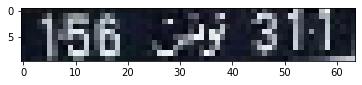

In [527]:
def extract_plate(image, box):
    """
    Extracts the subimage of box from the original image
    """
    xmin, ymin, xmax, ymax = box
    return image[ymin+2:ymax-2, xmin+2:xmax-2, :]

def split(char):
    nb_char = 1 + char.shape[1]//15
    width = char.shape[1] // nb_char
    if nb_char >1:
        lst_chars = []
        for c in range(nb_char):
            lst_chars.append(cv2.resize(char[:,c*width:(c+1)*width], (28,28), interpolation = cv2.INTER_AREA))
        return lst_chars
    return [cv2.resize(char, (28,28), interpolation = cv2.INTER_AREA)]

def segment_plate(plate, plates_dim= (70,20)):
    """
    segments the digits in the plate
    """
    plate = plate.astype(np.uint8)
    plate = cv2.cvtColor(plate, cv2.COLOR_RGB2GRAY)
    plate = cv2.resize(plate, (70,20), interpolation = cv2.INTER_AREA)
    ret, thresh = cv2.threshold(plate, 100, 255, cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    chars = []
    x_cntr_list =[]
    for i,contour in enumerate(contours) :
        intX, intY, intWidth, intHeight = cv2.boundingRect(contour)
        #checking the dimensions of the contour to filter out the characters by contour's size
        x_cntr_list.append((intX, intY, intWidth, intHeight ))
        if intHeight>=10 and intWidth>=3:
            char = plate[intY:intY+intHeight, intX:intX+intWidth]
            chars = chars + split(char)
            
    return chars, x_cntr_list


def plot_plate(plate):
    plt.imshow(plate)
    plt.show()

# new_images,
index = 150
xmin, ymin, xmax, ymax = new_targets.iloc[index][[ 'xmin', 'ymin',  'xmax', 'ymax']]
image = new_images[index]
plate = extract_plate(image,(xmin, ymin, xmax, ymax))
plot_plate(plate)

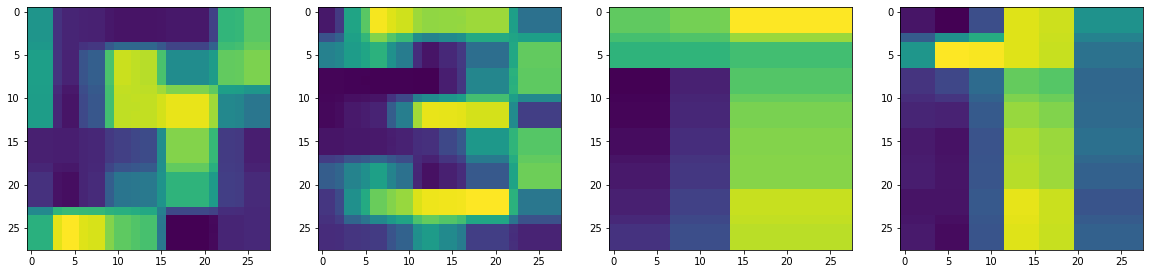

In [528]:
right_part = plate[:,-plate.shape[1]//2:,:]
chars, list_ = segment_plate(right_part)

fig, axs = plt.subplots(1, len(chars), figsize=(20,5))
for i in range(len(chars)):
    axs[i].imshow(chars[i])


## Characters Detection

The task here is to detect the value of each digit in the plate adn generate the number of the plate

**Responsible:** Hafsa

**Deadline:** Wednesday

In [547]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

In [549]:
resized_images = []
for i in range(len(data)):
    resized_images.append(cv2.resize(data[i].reshape(8,8), (28,28), interpolation = cv2.INTER_AREA)) 
    
data = np.expand_dims(np.array(resized_images), axis=-1)
labels = tf.keras.utils.to_categorical(
    labels, num_classes=10, dtype='float32'
)

In [554]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers


def get_char_cnn():
    model = Sequential()
    model.add(Conv2D(32, (5,5), input_shape=(28, 28, 1), activation='relu', padding='same'))
  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])
    model.summary()
    #loading pretrained weights saved using training char cnn
    return model

model = get_char_cnn()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                401472    
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 402,954
Trainable params: 402,954
Non-trainable params: 0
_______________________________________________

In [555]:
model.fit(data, labels, validation_split=0.15 , batch_size=32, epochs=50)

Epoch 1/50
48/48 [==============================] - 4s 65ms/step - loss: 2.6929 - accuracy: 0.2741 - val_loss: 0.8494 - val_accuracy: 0.7630
Epoch 2/50
48/48 [==============================] - 3s 54ms/step - loss: 0.8397 - accuracy: 0.7048 - val_loss: 0.5083 - val_accuracy: 0.8444
Epoch 3/50
48/48 [==============================] - 3s 60ms/step - loss: 0.3823 - accuracy: 0.8687 - val_loss: 0.4211 - val_accuracy: 0.8852
Epoch 4/50
48/48 [==============================] - 3s 70ms/step - loss: 0.2633 - accuracy: 0.9187 - val_loss: 0.3921 - val_accuracy: 0.8926
Epoch 5/50
48/48 [==============================] - 3s 55ms/step - loss: 0.1827 - accuracy: 0.9390 - val_loss: 0.3589 - val_accuracy: 0.9037
Epoch 6/50
48/48 [==============================] - 4s 78ms/step - loss: 0.1620 - accuracy: 0.9483 - val_loss: 0.3820 - val_accuracy: 0.9111
Epoch 7/50
48/48 [==============================] - 3s 66ms/step - loss: 0.1507 - accuracy: 0.9538 - val_loss: 0.3808 - val_accuracy: 0.8963
Epoch 8/50
48

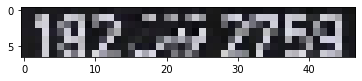

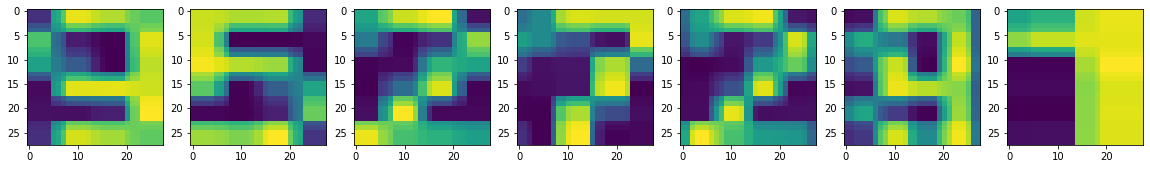

[5, 5, 2, 7, 2, 5, 3]

In [565]:
def recognise_digits(digits_images):
    lst = []
    for image in digits_images:
        image=np.expand_dims(image, axis=(0,-1))
        class_ = np.argmax(model(image)) 
        lst.append(class_)
    return lst

def get_plate_content(image, box, plot=True):
    """
    retruns the plate content limited 
    in the box of the image
    """
    plate_image =  extract_plate(image, box)
    if plot:
        plot_plate(plate_image)
    left_part = plate_image[:,:plate_image.shape[1]//2,:]
    right_part = plate_image[:,plate_image.shape[1]//2:,:]
    
    digits_image_right, _ = segment_plate(right_part)
    digits_image_left, _  = segment_plate(left_part)
    
    digits_image = digits_image_right[-4:] + digits_image_left[-3:]
    if plot:
        fig, axs = plt.subplots(1, len(digits_image), figsize=(20,5))
        for i in range(len(digits_image)):
            axs[i].imshow(digits_image[i])
        plt.show()
    plate_content = recognise_digits(digits_image)
    return plate_content

# new_images,
index = 12
xmin, ymin, xmax, ymax = new_targets.iloc[index][[ 'xmin', 'ymin',  'xmax', 'ymax']]
image = new_images[index]
get_plate_content(image,(xmin, ymin, xmax, ymax))

## Extra Tasks

### gh-pages of the project

**Responsible:** Amine

**Deadline:** Saturday

### Deploy the model on heroku site and provide a link to test in the README.m

**Responsible:** Hafsa

**Deadline:** Saturday